In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload 2

In [5]:
%matplotlib inline

In [6]:
import matplotlib.pylab as plt

In [7]:
from prepare_X import get_featrues, specs

df_features = get_featrues(specs)
df_features.index = df_features.index.date

df_features.head()

df_features.shape

transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV
feature: 97367270 has generated.
feature 97367270_lag1 has generated.
feature 97367270_lag2 has generated.
feature 97367270_lag3 has generated.
feature 97367270_lag4 has generated.
transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV
feature: 68488648 has generated.
feature 68488648_lag1 has generated.
feature 68488648_lag2 has generated.
feature 68488648_lag3 has generated.
feature 68488648_lag4 has generated.
transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV
feature: 56494646 has generated.
feature 56494646_lag1 has generated.
feature 56494646_lag2 has generated.
feature 56494646_lag3 has generated.
feature 56494646_lag4 has generated.
transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV
feature: 62918036 has generated.
feature 62918036_lag1 has generated.
feature 62918036_lag2 has generated.
feature 62918036_lag3 has generated.
feature 62918036_lag4 has generated.
transfor

(2000, 370)

In [56]:
from turnpt_analysis import get_df_turnpt_measures

N = 1
y = 'is_turnpt'

df_y = get_df_turnpt_measures(N).fillna(0)#NOTE: weighted by abs(prc_diff)
df_y.index = df_y.tx_datetime

df_chosen_y = df_y[[y]]

df_chosen_y.head()

transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV


,is_turnpt
tx_datetime,
2011-01-03,0.0
2011-01-04,0.0
2011-01-05,1.0
2011-01-06,-1.0
2011-01-07,1.0


# data

In [57]:
assert type(df_chosen_y.index.values[0]) == type(df_features.index.values[0])
df = df_chosen_y.join(df_features).dropna()

In [58]:
df.head();

In [59]:
df.shape

(1937, 371)

# https://github.com/catboost/tutorials

In [64]:
import numpy as np
from catboost import CatBoostClassifier, Pool

In [65]:
from catboost import CatBoostRegressor

In [66]:
num_train = int(df.shape[0] * 0.75)

In [67]:
y = df[y] 
y_train = y[: num_train]
y_test = y[num_train:]

In [68]:
X = df.iloc[:, 1:]
X_train = X.iloc[:num_train, :]
X_test = X.iloc[num_train:, :]

In [69]:
train_pool = Pool(X_train, y_train, weight=y_train.abs()+1)
test_pool = Pool(X_test, y_test, weight=y_test.abs()+1)

In [84]:
model = CatBoostClassifier(iterations=10**5, # set very large number and set early stops
                          depth=5, #fine-tune
                          learning_rate=0.5, #max: 0.5
                          loss_function='MultiClass', 
                          l2_leaf_reg = 200, #fine-tune
                          od_type = 'Iter',
                          od_wait = 250
                         )

In [85]:
model.fit(train_pool, eval_set=test_pool)

0:	learn: 1.0895940	test: 1.0895892	best: 1.0895892 (0)	total: 25.3ms	remaining: 42m 8s
1:	learn: 1.0814073	test: 1.0818332	best: 1.0818332 (1)	total: 41.2ms	remaining: 34m 20s
2:	learn: 1.0693834	test: 1.0701763	best: 1.0701763 (2)	total: 57.9ms	remaining: 32m 11s
3:	learn: 1.0587957	test: 1.0597364	best: 1.0597364 (3)	total: 74.2ms	remaining: 30m 54s
4:	learn: 1.0518918	test: 1.0531046	best: 1.0531046 (4)	total: 90.8ms	remaining: 30m 16s
5:	learn: 1.0478043	test: 1.0497220	best: 1.0497220 (5)	total: 108ms	remaining: 30m
6:	learn: 1.0427097	test: 1.0475341	best: 1.0475341 (6)	total: 127ms	remaining: 30m 16s
7:	learn: 1.0308095	test: 1.0371105	best: 1.0371105 (7)	total: 145ms	remaining: 30m 15s
8:	learn: 1.0221225	test: 1.0290762	best: 1.0290762 (8)	total: 163ms	remaining: 30m 7s
9:	learn: 1.0173859	test: 1.0253861	best: 1.0253861 (9)	total: 179ms	remaining: 29m 50s
10:	learn: 1.0140583	test: 1.0224764	best: 1.0224764 (10)	total: 195ms	remaining: 29m 28s
11:	learn: 1.0096891	test: 1.01

In [89]:
best_iter = model.best_iteration_
print(best_iter)

364


Fontconfig warning: ignoring UTF-8: not a valid region tag


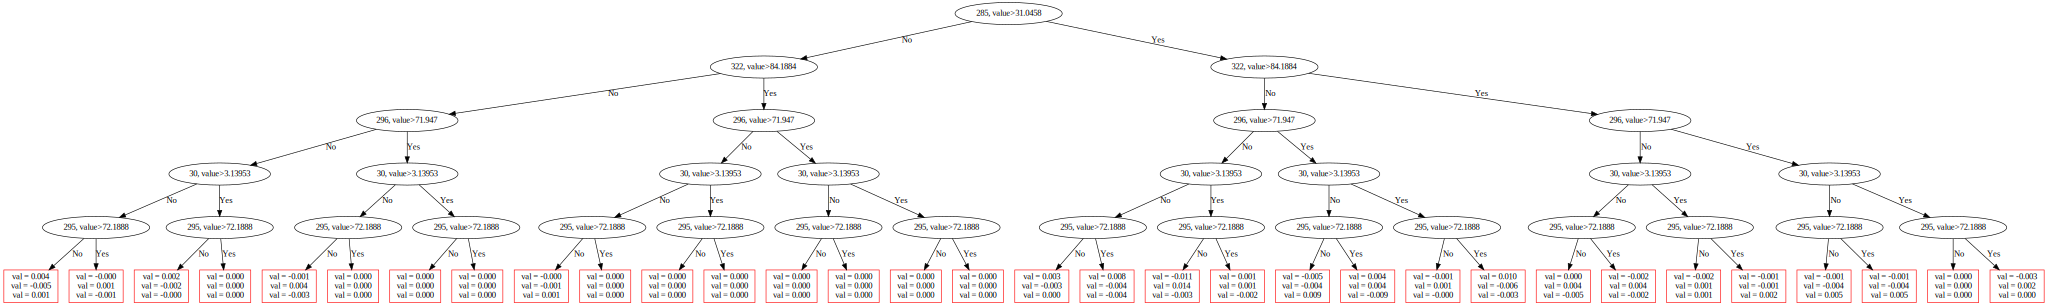

In [90]:
model.plot_tree(best_iter)

In [95]:
m = model.eval_metrics(train_pool, ['Precision', 'Recall'])
# m['Precision'][best_iter], m['Recall'][best_iter]

In [92]:
preds_class = model.predict(test_pool)
preds_proba = model.predict_proba(test_pool)
preds_raw = model.predict(test_pool, prediction_type='RawFormulaVal')

In [123]:
def get_precision_recall(model, pool):
    m = model.eval_metrics(pool, ['Precision', 'Recall'])

    df_prec_recall = pd.DataFrame([(class_, f'{m[f"Precision:class={idx}"][best_iter]*100:.2f} %', f'{m[f"Recall:class={idx}"][best_iter]*100:.2f} %') 
                  for idx, class_ in enumerate(model.classes_)
                 ], columns = ['class_', 'Precision', 'Recall'])
    return df_prec_recall


print('training pool')
get_precision_recall(model, train_pool)

print('testing pool')
get_precision_recall(model, test_pool)

training pool


,class_,Precision,Recall
0,-1.0,88.37 %,93.82 %
1,0.0,90.16 %,79.67 %
2,1.0,85.75 %,92.12 %


testing pool


,class_,Precision,Recall
0,-1.0,60.47 %,55.56 %
1,0.0,39.10 %,44.49 %
2,1.0,67.92 %,63.16 %


In [32]:
import pandas as pd

Text(0.5, 1.0, 'pred y')

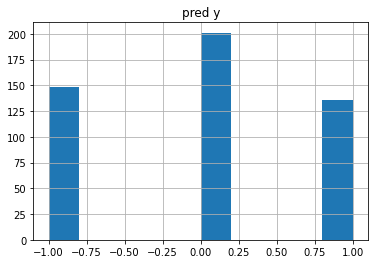

Text(0.5, 1.0, 'true y')

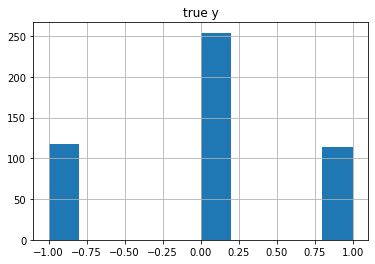

,y,pred,occurence
0,-1.0,-1.0,65
1,-1.0,0.0,48
2,-1.0,1.0,4
3,0.0,-1.0,81
4,0.0,0.0,113
5,0.0,1.0,60
6,1.0,-1.0,2
7,1.0,0.0,40
8,1.0,1.0,72


In [118]:
df_pred = (
    pd.DataFrame(model.predict(test_pool), columns=['pred'], index=y_test.index).
    assign(y=y_test)
)

df_pred.pred.hist()
plt.title('pred y')
plt.show()

df_pred.y.hist()
plt.title('true y')
plt.show()

df_pred_summary = df_pred.groupby(['y', 'pred']).size().to_frame('occurence').reset_index()
df_pred_summary

In [46]:
precision =  df_pred_summary.query('(y==1) and (pred==1)').occurence.iloc[0] / df_pred_summary.query('(y==1)').occurence.sum()
precision

0.5263157894736842

In [35]:
recall = df_pred_summary.query('(y==1) and (pred==1)').occurence.iloc[0] / df_pred_summary.query('(y==1)').occurence.sum() 
recall

0.5263157894736842

# plot entry and exit

In [124]:
def plot_turnpt(df_turnpt_ohlc, N):
    df_plot = df_turnpt_ohlc.copy()
    df_plot.set_index('tx_datetime', inplace=True)
    def find_loc(df, dates):
        return [df.index.get_loc(date) for date in dates]
    
    dates_upward = df_plot.query(f'(N == {N}) and (is_turnpt_upward==1)').index
    df_plot.close.plot.line(figsize=(20, 5), color='white', markevery=find_loc(df_plot, dates_upward), marker='^', markerfacecolor='red', markeredgewidth=0.0)

    dates_downward = df_plot.query(f'(N == {N}) and (is_turnpt_downward==1)').index
    df_plot.close.plot.line(figsize=(20, 5), color='black', markevery=find_loc(df_plot, dates_downward), marker='v', markerfacecolor='green', markeredgewidth=0.0)
    plt.title(f'N: {N}')

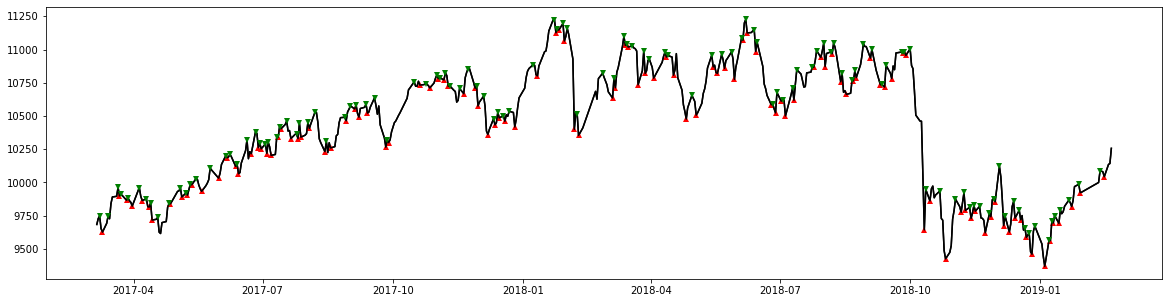

In [205]:
def plot_turnpt(price, turnpts, dates_index):
    index_upward = np.where(turnpts==1)[0]
    index_downward = np.where(turnpts==-1)[0]
    
    plt.figure(figsize=(20, 5))
    plt.plot(dates_index, price, color='black', markevery=index_upward.tolist(), marker='^', markerfacecolor='red', markeredgewidth=0.0)
    plt.plot(dates_index, price, color='black', markevery=index_downward.tolist(), marker='v', markerfacecolor='green', markeredgewidth=0.0)


test_df_y = df_y[df_y.index.isin(y_test.index)]
test_price = test_df_y.close.values
test_turnpts_true = test_df_y.is_turnpt.values
test_dates_index = test_df_y.index
plot_turnpt(test_price, test_turnpts_true, test_dates_index)

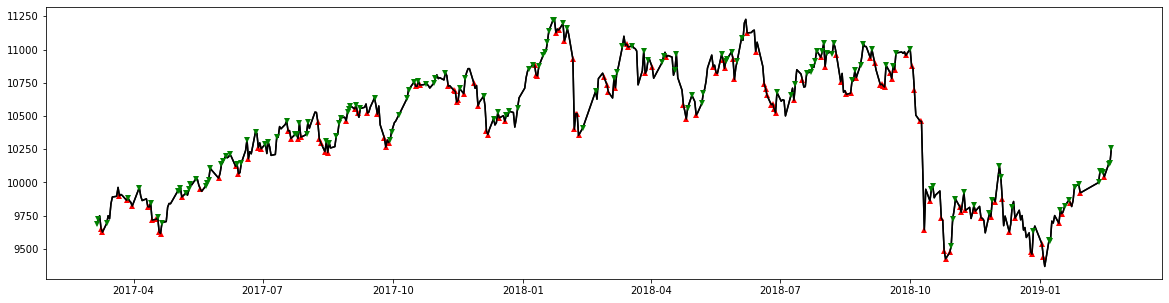

In [226]:
def get_predict_class(model, pool, threshold = 0):
    max_prob = model.predict_proba(pool).max(axis=1)
    turnpts_pred = model.predict(pool).flatten()
    turnpts_pred_filtered = np.where(max_prob>=threshold, turnpts_pred, 0)
    return turnpts_pred_filtered

test_turnpts_pred = get_predict_class(model, test_pool)
plot_turnpt(test_price, test_turnpts_pred, test_dates_index)

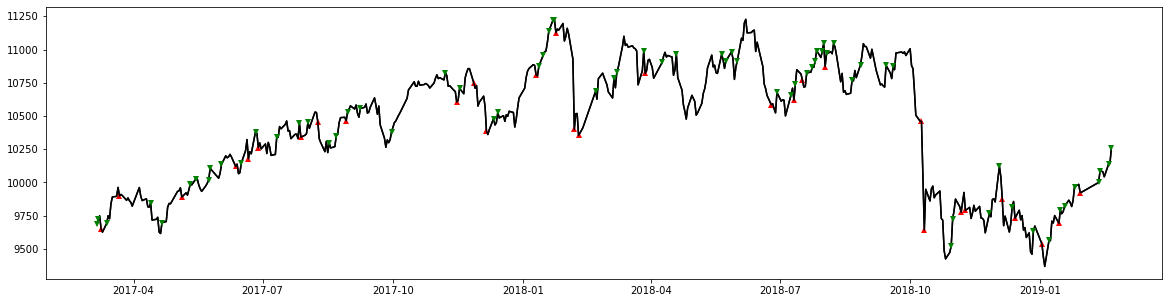

In [228]:
# only plot 1 or -1 when prob > thereshold
# noises during 2018-M7 disappear
test_turnpts_pred = get_predict_class(model, test_pool, threshold=0.6)
plot_turnpt(test_price, test_turnpts_pred, test_dates_index)

# plot NAV

In [231]:
test_df_y['is_turnpt_pred'] = get_predict_class(model, test_pool)
test_df_y.head()

<ipython-input-231-74b3a4708c79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_y['is_turnpt_pred'] =get_predict_class(model, test_pool)


,tx_datetime,N,open,high,low,close,vol,maturity,day_to_maturity,is_turnpt_upward,is_turnpt_downward,is_turnpt,next_dt_turnpt,prc_diff,duration,slope,is_turnpt_pred
tx_datetime,,,,,,,,,,,,,,,,,
2017-03-06,2017-03-06,1,9639.0,9684.0,9619.0,9683.0,196244.0,2017-03-15,-9,0.0,0.0,0.0,2017-03-07,44.0,1,44.000000,-1.0
2017-03-07,2017-03-07,1,9693.0,9734.0,9682.0,9727.0,188700.0,2017-03-15,-8,0.0,0.0,0.0,2017-03-08,21.0,1,21.000000,-1.0
2017-03-08,2017-03-08,1,9736.0,9765.0,9701.0,9748.0,226610.0,2017-03-15,-7,0.0,1.0,-1.0,2017-03-09,-96.0,1,-96.000000,0.0
2017-03-09,2017-03-09,1,9739.0,9742.0,9642.0,9652.0,277266.0,2017-03-15,-6,0.0,0.0,0.0,2017-03-10,-27.0,1,-27.000000,1.0
2017-03-10,2017-03-10,1,9647.0,9652.0,9555.0,9625.0,307656.0,2017-03-15,-5,1.0,0.0,1.0,2017-03-13,67.0,3,22.333333,1.0


In [248]:
# test_df_y
(
    test_df_y.query('is_turnpt_pred != 0').loc[:, ['tx_datetime', 'close']].
    assign(entry = lambda x: x.tx_datetime, 
           exit = lambda x: x.tx_datetime.shift(-1)).dropna().
    assign(p_entry = lambda x: x.close.loc[x.entry],# 
#            p_exit = lambda x: x.close[x.exit],# 
#            ret = lambda x: x.p_exit.div(x.p_entry)-1
    )
#     loc[:, ['entry', 'exit']].
#     join(test_df_y, how='right')
)

,tx_datetime,close,entry,exit,p_entry
tx_datetime,,,,,
2017-03-06,2017-03-06,9683.0,2017-03-06,2017-03-07,9683.0
2017-03-07,2017-03-07,9727.0,2017-03-07,2017-03-09,9727.0
2017-03-09,2017-03-09,9652.0,2017-03-09,2017-03-10,9652.0
2017-03-10,2017-03-10,9625.0,2017-03-10,2017-03-13,9625.0
2017-03-13,2017-03-13,9692.0,2017-03-13,2017-03-22,9692.0
...,...,...,...,...,...
2019-02-13,2019-02-13,10084.0,2019-02-13,2019-02-14,10084.0
2019-02-14,2019-02-14,10080.0,2019-02-14,2019-02-15,10080.0
2019-02-15,2019-02-15,10042.0,2019-02-15,2019-02-18,10042.0


# show metrics